In [1]:
import sys; sys.argv=['']; del sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_data, process_graph_data
from utils import package_mxl, adj_rw_norm
from utils import sparse_mx_to_torch_sparse_tensor
from utils import ResultRecorder

from model import GCN, GCNBias, SGC, ResGCN, GCNII, APPNP, MLP
from load_semigcn_data import load_data_gcn
from data_loader import DataLoader

import numpy as np
import copy 
import time
from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import trange
from scipy.sparse.csgraph import connected_components
import pickle
import os
import math

In [3]:
import sys; sys.argv=['']; del sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import argparse
"""
Dataset arguments
"""
parser = argparse.ArgumentParser(
    description='Training GCN on Large-scale Graph Datasets')
parser.add_argument('--dataset', type=str, default='cora',
                    help='Dataset name: pubmed/flickr/reddit/ppi-large')
parser.add_argument('--method', type=str, default='GCN/ResGCN/GCNII/APPNP/DGCN', # SGC/GCN/GCNBias/ResGCN/GCNII/APPNP
                    help='Algorithms: seperate using slash')
parser.add_argument('--nhid', type=int, default=64,
                    help='Hidden state dimension')
parser.add_argument('--epoch_num', type=int, default=300,
                    help='Number of Epoch')
parser.add_argument('--batch_size', type=int, default=20480000000,
                    help='size of output node in a batch')
parser.add_argument('--n_layers', type=int, default=8,
                    help='Number of GCN layers')
parser.add_argument('--dropout', type=float, default=0,
                    help='Dropout rate')
parser.add_argument('--cuda', type=int, default=0,
                    help='Avaiable GPU ID')
args = parser.parse_args()
print(args)

method = args.method.split('/')

"""
Prepare devices
"""
if args.cuda != -1:
    device = torch.device("cuda:" + str(args.cuda))
else:
    device = torch.device("cpu")
    
if args.dataset not in ['cora', 'citeseer', 'pubmed']:
    temp_data = load_data(args.dataset) 
else:
    temp_data = load_data_gcn(args.dataset)

adj_full, adj_train, feat_data, labels, role = process_graph_data(*temp_data)

train_nodes = np.array(role['tr'])
valid_nodes = np.array(role['va'])
test_nodes = np.array(role['te'])

data_loader = DataLoader(adj_full, train_nodes, valid_nodes, test_nodes, device)

Namespace(batch_size=20480000000, cuda=0, dataset='cora', dropout=0, epoch_num=300, method='GCN/ResGCN/GCNII/APPNP/DGCN', n_layers=8, nhid=64)


In [4]:
"""
Setup datasets and models for training (multi-class use sigmoid+binary_cross_entropy, use softmax+nll_loss otherwise)
"""

if args.dataset in ['flickr', 'reddit', 'cora', 'citeseer', 'pubmed']:
    feat_data_th = torch.FloatTensor(feat_data)
    labels_th = torch.LongTensor(labels.argmax(1))
    num_classes = labels_th.max().item()+1
    criterion = nn.CrossEntropyLoss()
    multi_class=False
elif args.dataset in ['ppi', 'ppi-large', 'amazon', 'yelp']:
    feat_data_th = torch.FloatTensor(feat_data)
    labels_th = torch.FloatTensor(labels)
    num_classes = labels_th.shape[1]
    criterion = nn.BCEWithLogitsLoss()
    multi_class=True

feat_data_th = feat_data_th.to(device)
labels_th = labels_th.to(device)

def sgd_step(net, optimizer, feat_data, labels, train_data, device):
    """
    Function to updated weights with a SGD backpropagation
    args : net, optimizer, train_loader, test_loader, loss function, number of inner epochs, args
    return : train_loss, test_loss, grad_norm_lb
    """
    net.train()
    epoch_loss = []
    epoch_acc = []
    
    # Run over the train_loader
    mini_batches, adj = train_data
    for mini_batch in mini_batches:

        # compute current stochastic gradient
        optimizer.zero_grad()
        output = net(feat_data, adj)
        
        loss = net.criterion(output[mini_batch], labels[mini_batch])
        loss.backward()
        
        optimizer.step()
        epoch_loss.append(loss.item())
        
        if multi_class:
            output[output > 0.5] = 1
            output[output <= 0.5] = 0
        else:
            output = output.argmax(dim=1)

        acc = f1_score(output[mini_batch].detach().cpu(), 
                       labels[mini_batch].detach().cpu(), average="micro")
        epoch_acc.append(acc)

    return epoch_loss, epoch_acc

@torch.no_grad()
def inference(eval_model, feat_data, labels, test_data, device):
    eval_model = eval_model.to(device)
    mini_batch, adj = test_data    
    output = eval_model(feat_data, adj)
    loss = eval_model.criterion(output[mini_batch], labels[mini_batch]).item()
    
    if multi_class:
        output[output > 0.5] = 1
        output[output <= 0.5] = 0
    else:
        output = output.argmax(dim=1)
        
    acc = f1_score(output[mini_batch].detach().cpu(), 
                   labels[mini_batch].detach().cpu(), average="micro")
    return loss, acc

In [5]:
"""
Train without sampling
"""

def train_model(model, data_loader, note):
    train_model = copy.deepcopy(model).to(device)
    
    results = ResultRecorder(note=note)
    
    optimizer = optim.Adam(train_model.parameters())

    tbar = trange(args.epoch_num, desc='Training Epochs')
    for epoch in tbar:
        # fetch train data 
        
        sample_time_st = time.perf_counter()
        train_data = data_loader.get_mini_batches(batch_size=args.batch_size)
        sample_time = time.perf_counter() - sample_time_st
        
        compute_time_st = time.perf_counter()
        train_loss, train_acc = sgd_step(train_model, optimizer, feat_data_th, labels_th, train_data, device)
        compute_time = time.perf_counter() - compute_time_st
        
        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)

        valid_data = data_loader.get_valid_batch()
        epoch_valid_loss, epoch_valid_acc = inference(train_model, feat_data_th, labels_th, valid_data, device)
        tbar.set_postfix(loss=epoch_train_loss,
                         val_loss=epoch_valid_loss,
                         val_score=epoch_valid_acc)

        results.update(epoch_train_loss, 
                       epoch_train_acc,
                       epoch_valid_loss, 
                       epoch_valid_acc, 
                       train_model, sample_time=sample_time, compute_time=compute_time)
            
    print('Average sampling time %.5fs, average computing time %.5fs'%
          (np.mean(results.sample_time), np.mean(results.compute_time)))
    
    return results

In [6]:
import math

In [7]:

    
    
class GCN(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, criterion):
        from layers import GraphConv
        super(GCN, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        self.gcs.append(GraphConv(n_feat,  n_hid))
        for _ in range(n_layers-1):
            self.gcs.append(GraphConv(n_hid,  n_hid))
        self.linear = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.criterion = criterion

    def forward(self, x, adj):
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj)
            x = self.relu(x)
        x = self.linear(x)
        return x
    
class ResGCN(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, criterion):
        from layers import GraphConv
        super(ResGCN, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        self.gcs.append(GraphConv(n_feat,  n_hid))
        for _ in range(n_layers-1):
            self.gcs.append(GraphConv(n_hid,  n_hid))
        self.linear = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.criterion = criterion

    def forward(self, x, adj):
        for ell in range(len(self.gcs)):
            if ell > 0:
                x_res = x.clone()
                x = self.gcs[ell](x, adj)
                x = self.relu(x) + x_res
            else:
                x = self.gcs[ell](x, adj)
                x = self.relu(x)
        x = self.linear(x)
        return x
    
class GCNII(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, criterion):
        from layers import GCNIILayer
        super(GCNII, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(GCNIILayer(n_hid,  n_hid))
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.criterion = criterion

    def get_alpha_beta(self, ell):
        alpha = 0.9
        beta = math.log(0.5/(ell+1)+1)
        return alpha, beta
    
    def forward(self, x, adj):
        x = self.linear_in(x)
        x_0 = x.clone()
        for ell in range(len(self.gcs)):
            alpha, beta = self.get_alpha_beta(ell)
            x = self.gcs[ell](x, adj, x_0, alpha, beta)
            x = self.relu(x)
        x = self.linear_out(x)
        return x
    
class APPNP(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, criterion):
        from layers import APPNPLayer
        super(APPNP, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(APPNPLayer())
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.criterion = criterion

    def forward(self, x, adj):
        x = self.linear_in(x)
        x_0 = x.clone()
        for ell in range(len(self.gcs)):
            alpha = 0.8
            x = self.gcs[ell](x, adj, x_0, alpha)
        x = self.linear_out(x)
        return x
    
class DGCN(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, criterion):
        from layers import DecoupleConv
        super(DGCN, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        self.softmax = nn.Softmax(dim=0)
        self.sigmoid = nn.Sigmoid()
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(DecoupleConv(n_hid,  n_hid))
            
        alpha = 0.1
        TEMP=alpha*(1-alpha)**np.arange(self.n_layers+1)
        TEMP[-1] = (1-alpha)**self.n_layers
        TEMP = np.log(TEMP)
        self.layer_weight = torch.nn.Parameter(torch.tensor(TEMP))
        self.identity_map_weight = torch.nn.Parameter(torch.zeros(self.n_layers))
        
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.criterion = criterion
    
    def forward(self, x, adj):
        x = self.linear_in(x)
        identity_map_weight = self.sigmoid(self.identity_map_weight)
        
        output_hiddens = []
        for ell in range(len(self.gcs)):
            x, x_w = self.gcs[ell](x, adj, identity_map_weight[ell])
            x_w = self.relu(x_w)
            output_hiddens.append(x_w)
            
        layer_weight = self.softmax(self.layer_weight)  
        for i in range(len(output_hiddens)):
            output_hiddens[i] = output_hiddens[i] * layer_weight[i]
            
        x = sum(output_hiddens)
        x = self.linear_out(x)
        return x

In [8]:
algorithm_result = dict()
algorithm_result['GCN'] = []
algorithm_result['ResGCN'] = []
algorithm_result['GCNII'] = []
algorithm_result['APPNP'] = []
algorithm_result['DGCN'] = []

print(method)

['GCN', 'ResGCN', 'GCNII', 'APPNP', 'DGCN']


In [9]:
for repeat in range(10):
    if 'GCN' in method:
        model = GCN(n_feat=feat_data.shape[1], 
                    n_hid=args.nhid, 
                    n_classes=num_classes, 
                    n_layers=args.n_layers, 
                    criterion=criterion)

        results = train_model(model, data_loader, note="GCN (L=%d, repeat=%d)"%(args.n_layers, repeat))
        results = np.array([
            results.train_loss_record,
            results.train_acc_record,
            results.loss_record,
            results.acc_record
        ])
        algorithm_result['GCN'].append(results)

    if 'ResGCN' in method:
        model = ResGCN(n_feat=feat_data.shape[1], 
                    n_hid=args.nhid, 
                    n_classes=num_classes, 
                    n_layers=args.n_layers, 
                    criterion=criterion)

        results = train_model(model, data_loader, note="ResGCN (L=%d, repeat=%d)"%(args.n_layers, repeat))
        results = np.array([
            results.train_loss_record,
            results.train_acc_record,
            results.loss_record,
            results.acc_record
        ])
        algorithm_result['ResGCN'].append(results)

    if 'GCNII' in method:
        model = GCNII(n_feat=feat_data.shape[1], 
                    n_hid=args.nhid, 
                    n_classes=num_classes, 
                    n_layers=args.n_layers, 
                    criterion=criterion)

        results = train_model(model, data_loader, note="GCNII (L=%d, repeat=%d)"%(args.n_layers, repeat))
        results = np.array([
            results.train_loss_record,
            results.train_acc_record,
            results.loss_record,
            results.acc_record
        ])
        algorithm_result['GCNII'].append(results)
        
    if 'APPNP' in method:
        model = APPNP(n_feat=feat_data.shape[1], 
                    n_hid=args.nhid, 
                    n_classes=num_classes, 
                    n_layers=args.n_layers, 
                    criterion=criterion)

        results = train_model(model, data_loader, note="APPNP (L=%d, repeat=%d)"%(args.n_layers, repeat))
        results = np.array([
            results.train_loss_record,
            results.train_acc_record,
            results.loss_record,
            results.acc_record
        ])
        algorithm_result['APPNP'].append(results)
        
    if 'DGCN' in method:
        model = DGCN(n_feat=feat_data.shape[1], 
                    n_hid=args.nhid, 
                    n_classes=num_classes, 
                    n_layers=args.n_layers, 
                    criterion=criterion)

        results = train_model(model, data_loader, note="DGCN (L=%d, repeat=%d)"%(args.n_layers, repeat))
        results = np.array([
            results.train_loss_record,
            results.train_acc_record,
            results.loss_record,
            results.acc_record
        ])
        algorithm_result['DGCN'].append(results)

Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 58.06it/s, loss=1.55, val_loss=1.51, val_score=0.316]

Average sampling time 0.00005s, average computing time 0.01017s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 60.48it/s, loss=1.84, val_loss=1.84, val_score=0.294]

Average sampling time 0.00006s, average computing time 0.01024s


Training Epochs:   3%|▎         | 8/300 [00:00<00:03, 76.02it/s, loss=1.69, val_loss=1.68, val_score=0.312]

Average sampling time 0.00005s, average computing time 0.01089s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 50.77it/s, loss=1.91, val_loss=1.9, val_score=0.268] 

Average sampling time 0.00005s, average computing time 0.00849s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 62.41it/s, loss=1.97, val_loss=1.97, val_score=0.158]

Average sampling time 0.00006s, average computing time 0.01259s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 58.62it/s, loss=1.65, val_loss=1.65, val_score=0.296]

Average sampling time 0.00005s, average computing time 0.00995s


Training Epochs:   2%|▏         | 6/300 [00:00<00:04, 59.67it/s, loss=1.86, val_loss=1.84, val_score=0.314]

Average sampling time 0.00005s, average computing time 0.01027s


Training Epochs:   3%|▎         | 8/300 [00:00<00:03, 73.37it/s, loss=1.68, val_loss=1.68, val_score=0.368]

Average sampling time 0.00005s, average computing time 0.01087s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 50.52it/s, loss=1.94, val_loss=1.93, val_score=0.326]

Average sampling time 0.00005s, average computing time 0.00847s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 62.17it/s, loss=1.94, val_loss=1.94, val_score=0.158]

Average sampling time 0.00005s, average computing time 0.01253s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 58.52it/s, loss=1.49, val_loss=1.46, val_score=0.434]

Average sampling time 0.00005s, average computing time 0.00999s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 56.72it/s, loss=1.87, val_loss=1.86, val_score=0.444]

Average sampling time 0.00005s, average computing time 0.01024s


Training Epochs:   3%|▎         | 8/300 [00:00<00:03, 74.45it/s, loss=1.65, val_loss=1.65, val_score=0.446]

Average sampling time 0.00005s, average computing time 0.01090s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 52.12it/s, loss=1.93, val_loss=1.93, val_score=0.142]

Average sampling time 0.00005s, average computing time 0.00848s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 63.50it/s, loss=1.91, val_loss=1.91, val_score=0.294]

Average sampling time 0.00005s, average computing time 0.01259s


Training Epochs:   2%|▏         | 6/300 [00:00<00:04, 59.65it/s, loss=1.59, val_loss=1.55, val_score=0.296]

Average sampling time 0.00005s, average computing time 0.00993s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 55.96it/s, loss=1.92, val_loss=1.91, val_score=0.324]

Average sampling time 0.00005s, average computing time 0.01024s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 53.28it/s, loss=1.74, val_loss=1.74, val_score=0.416]

Average sampling time 0.00005s, average computing time 0.01093s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 51.45it/s, loss=1.91, val_loss=1.91, val_score=0.246]

Average sampling time 0.00005s, average computing time 0.00846s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 61.82it/s, loss=1.95, val_loss=1.95, val_score=0.158]

Average sampling time 0.00005s, average computing time 0.01252s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 60.45it/s, loss=1.57, val_loss=1.55, val_score=0.34] 

Average sampling time 0.00005s, average computing time 0.00994s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 56.25it/s, loss=1.9, val_loss=1.89, val_score=0.358] 

Average sampling time 0.00005s, average computing time 0.01022s


Training Epochs:   3%|▎         | 8/300 [00:00<00:04, 71.40it/s, loss=1.68, val_loss=1.67, val_score=0.364]

Average sampling time 0.00005s, average computing time 0.01100s


Training Epochs:   2%|▏         | 5/300 [00:00<00:06, 48.65it/s, loss=1.94, val_loss=1.93, val_score=0.28] 

Average sampling time 0.00006s, average computing time 0.00859s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 63.19it/s, loss=1.94, val_loss=1.94, val_score=0.348]

Average sampling time 0.00005s, average computing time 0.01252s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 58.39it/s, loss=1.51, val_loss=1.49, val_score=0.314]

Average sampling time 0.00005s, average computing time 0.00991s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 54.70it/s, loss=1.89, val_loss=1.89, val_score=0.38] 

Average sampling time 0.00005s, average computing time 0.01027s


Training Epochs:   3%|▎         | 8/300 [00:00<00:03, 74.17it/s, loss=1.7, val_loss=1.7, val_score=0.362]  

Average sampling time 0.00005s, average computing time 0.01091s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 50.51it/s, loss=1.91, val_loss=1.91, val_score=0.27] 

Average sampling time 0.00005s, average computing time 0.00849s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 62.66it/s, loss=1.95, val_loss=1.95, val_score=0.172]

Average sampling time 0.00005s, average computing time 0.01252s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 56.94it/s, loss=1.56, val_loss=1.53, val_score=0.384]

Average sampling time 0.00005s, average computing time 0.00994s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 60.26it/s, loss=1.83, val_loss=1.82, val_score=0.294]

Average sampling time 0.00005s, average computing time 0.01028s


Training Epochs:   3%|▎         | 8/300 [00:00<00:04, 72.55it/s, loss=1.66, val_loss=1.66, val_score=0.344]

Average sampling time 0.00005s, average computing time 0.01089s


Training Epochs:   2%|▏         | 5/300 [00:00<00:05, 49.90it/s, loss=1.9, val_loss=1.9, val_score=0.294]  

Average sampling time 0.00005s, average computing time 0.00851s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 62.06it/s, loss=1.94, val_loss=1.94, val_score=0.072]

Average sampling time 0.00005s, average computing time 0.01257s


Training Epochs:   2%|▏         | 6/300 [00:00<00:04, 59.81it/s, loss=1.49, val_loss=1.45, val_score=0.466]

Average sampling time 0.00005s, average computing time 0.00992s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 55.03it/s, loss=1.88, val_loss=1.87, val_score=0.342]

Average sampling time 0.00005s, average computing time 0.01026s


Training Epochs:   3%|▎         | 8/300 [00:00<00:03, 73.36it/s, loss=1.66, val_loss=1.66, val_score=0.322]

Average sampling time 0.00005s, average computing time 0.01087s


Training Epochs:   2%|▏         | 5/300 [00:00<00:05, 49.26it/s, loss=1.91, val_loss=1.9, val_score=0.318] 

Average sampling time 0.00005s, average computing time 0.00852s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 63.30it/s, loss=1.93, val_loss=1.93, val_score=0.174]

Average sampling time 0.00005s, average computing time 0.01253s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 58.63it/s, loss=1.5, val_loss=1.48, val_score=0.296] 

Average sampling time 0.00005s, average computing time 0.00994s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 56.62it/s, loss=1.9, val_loss=1.89, val_score=0.264] 

Average sampling time 0.00005s, average computing time 0.01025s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 68.41it/s, loss=1.71, val_loss=1.71, val_score=0.322]

Average sampling time 0.00005s, average computing time 0.01090s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 54.38it/s, loss=1.9, val_loss=1.89, val_score=0.302] 

Average sampling time 0.00005s, average computing time 0.00851s


Training Epochs:   2%|▏         | 7/300 [00:00<00:04, 62.12it/s, loss=1.95, val_loss=1.95, val_score=0.078]

Average sampling time 0.00005s, average computing time 0.01251s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 58.66it/s, loss=1.55, val_loss=1.51, val_score=0.344]

Average sampling time 0.00005s, average computing time 0.00998s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 56.28it/s, loss=1.89, val_loss=1.89, val_score=0.44] 

Average sampling time 0.00005s, average computing time 0.01026s


Training Epochs:   3%|▎         | 8/300 [00:00<00:04, 71.78it/s, loss=1.68, val_loss=1.68, val_score=0.388]

Average sampling time 0.00005s, average computing time 0.01090s


Training Epochs:   2%|▏         | 6/300 [00:00<00:05, 53.12it/s, loss=1.88, val_loss=1.87, val_score=0.294]

Average sampling time 0.00005s, average computing time 0.00849s


Training Epochs: 100%|██████████| 300/300 [00:05<00:00, 52.59it/s, loss=0.0308, val_loss=0.471, val_score=0.866]

Average sampling time 0.00005s, average computing time 0.01253s


In [10]:
def get_mean_std_epoch_result(all_epoch_results):

    all_train_loss = []
    all_valid_loss = []
    all_train_acc = []
    all_valid_acc = []
    all_gen_error = []

    for epoch_results in all_epoch_results:
        all_train_loss.append(epoch_results[0,:])
        all_valid_loss.append(epoch_results[2,:])
        all_train_acc.append(epoch_results[1,:])
        all_valid_acc.append(epoch_results[3,:])
        all_gen_error.append(epoch_results[2,:] - epoch_results[0,:])

    all_epoch_results_mean = np.array([np.mean(all_train_loss, axis=0),
                                       np.mean(all_valid_loss, axis=0),
                                       np.mean(all_train_acc, axis=0),
                                       np.mean(all_valid_acc, axis=0),
                                       np.mean(all_gen_error, axis=0)])

    all_epoch_results_std = np.array([np.std(all_train_loss, axis=0),
                                      np.std(all_valid_loss, axis=0),
                                      np.std(all_train_acc, axis=0),
                                      np.std(all_valid_acc, axis=0),
                                      np.std(all_gen_error, axis=0)])
    
    return all_epoch_results_mean, all_epoch_results_std

(5, 300) (5, 300)
GCN 0.3898172855377197
(5, 300) (5, 300)
ResGCN 0.23377364575862886
(5, 300) (5, 300)
GCNII 0.16348545551300048
(5, 300) (5, 300)
APPNP 0.15541138201951982
(5, 300) (5, 300)
DGCN 0.12438304722309113


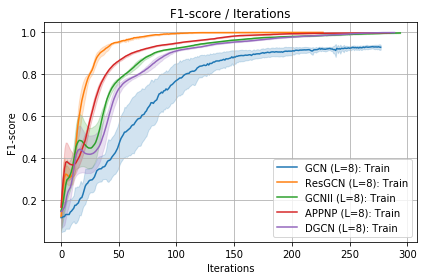

In [11]:
fig, axs = plt.subplots()
n_layers = args.n_layers
for algorithm in ['GCN', 'ResGCN', 'GCNII', 'APPNP', 'DGCN']:
    color = next(axs._get_lines.prop_cycler)['color']
    
    all_epoch_results = algorithm_result[algorithm]
    all_epoch_results_mean, all_epoch_results_std = get_mean_std_epoch_result(all_epoch_results)
    print(all_epoch_results_mean.shape, all_epoch_results_std.shape)
    
    best_iter = np.argmax(all_epoch_results_mean[3]) # valid acc
    stop_iter = np.argmax(all_epoch_results_mean[2]) # train acc

    y_vals = all_epoch_results_mean[2][:stop_iter]
    y_stds = all_epoch_results_std[2][:stop_iter]
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s (L=%d): Train'%(algorithm, n_layers), color=color, linestyle='-')
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.2, color=color)

#     y_vals = all_epoch_results_mean[3][:stop_iter]
#     y_stds = all_epoch_results_std[3][:stop_iter]
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s (L=%d): Valid'%(algorithm, n_layers), color=color, linestyle='--')
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.2, color=color)
    
    print(algorithm, all_epoch_results_mean[4][best_iter])

plt.title('F1-score / Iterations')
axs.set_ylabel('F1-score')
axs.set_xlabel('Iterations')
axs.grid(True)
fig.tight_layout()
plt.legend()
plt.savefig('f1_score_synthetic.pdf')
# plt.close()

In [12]:
all_epoch_results_mean.shape

(5, 300)

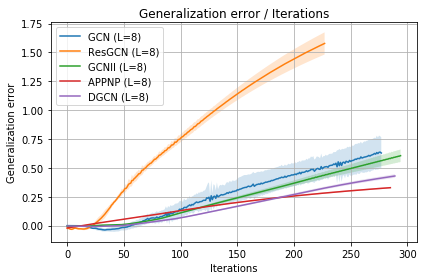

In [13]:
fig, axs = plt.subplots()

for algorithm in ['GCN', 'ResGCN', 'GCNII', 'APPNP', 'DGCN']:
    
    all_epoch_results = algorithm_result[algorithm]
    all_epoch_results_mean, all_epoch_results_std = get_mean_std_epoch_result(all_epoch_results)

    best_iter = np.argmax(all_epoch_results_mean[3])
    stop_iter = np.argmax(all_epoch_results_mean[2])
    
    y_vals = all_epoch_results_mean[4][:stop_iter]
    y_stds = all_epoch_results_std[4][:stop_iter]
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s (L=%d)'%(algorithm, n_layers))
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.2)


plt.title('Generalization error / Iterations')
axs.set_ylabel('Generalization error')
axs.set_xlabel('Iterations')
axs.grid(True)
fig.tight_layout()
plt.legend()
plt.savefig('generalization_error_synthetic.pdf')
# plt.close()